In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv(r"C:\Users\jacob\Kod_vscode\Databehandling\athlete_events.csv")


In [4]:
print(df['NOC'].nunique())
print(df['NOC'])

230
0         CHN
1         CHN
2         DEN
3         DEN
4         NED
         ... 
271111    POL
271112    POL
271113    POL
271114    POL
271115    POL
Name: NOC, Length: 271116, dtype: object


In [5]:
df['Sport']

0            Basketball
1                  Judo
2              Football
3            Tug-Of-War
4         Speed Skating
              ...      
271111             Luge
271112      Ski Jumping
271113      Ski Jumping
271114        Bobsleigh
271115        Bobsleigh
Name: Sport, Length: 271116, dtype: object

 e. ta reda på statistik för åldern: medelvärde, median, min, max, standardavvikelse,

In [6]:
print(df['Age'].mean())
print(df['Age'].median())
print(df['Age'].min())
print(df['Age'].max())
print(df['Age'].std())

25.556898357297374
24.0
10.0
97.0
6.393560847035813


In [7]:
df = df.fillna({'Age': 0, 'Height': 0, 'Weight': 0, 'ID': 0})
df = df.astype({'Age': 'uint8', 'Height': 'uint8', 'Weight': 'uint8', 'ID': 'uint32' , 'Year': 'int16'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      271116 non-null  uint32
 1   Name    271116 non-null  object
 2   Sex     271116 non-null  object
 3   Age     271116 non-null  uint8 
 4   Height  271116 non-null  uint8 
 5   Weight  271116 non-null  uint8 
 6   Team    271116 non-null  object
 7   NOC     271116 non-null  object
 8   Games   271116 non-null  object
 9   Year    271116 non-null  int16 
 10  Season  271116 non-null  object
 11  City    271116 non-null  object
 12  Sport   271116 non-null  object
 13  Event   271116 non-null  object
 14  Medal   39783 non-null   object
dtypes: int16(1), object(10), uint32(1), uint8(3)
memory usage: 23.0+ MB


<Axes: xlabel='Sex'>

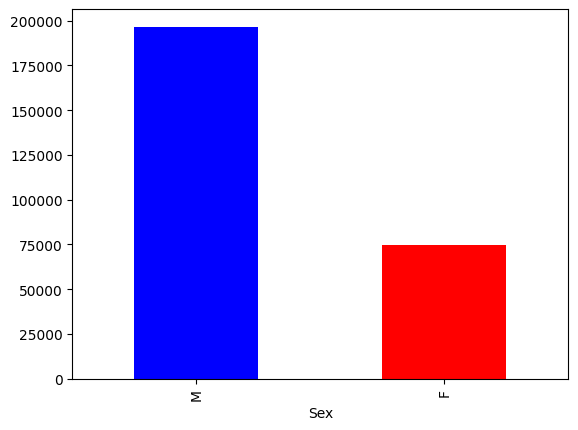

In [8]:
df['Sex'].value_counts().plot(kind='bar', color=['blue', 'red'])

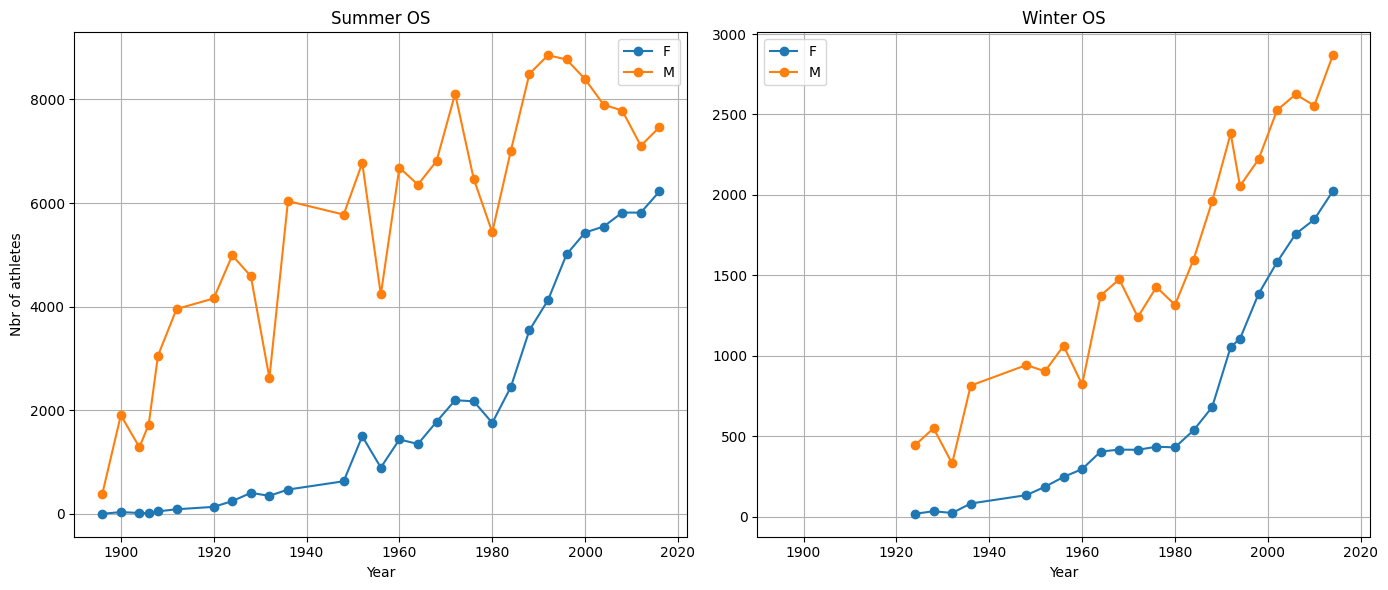

In [9]:

gender_year_season = df.groupby(['Season', 'Year', 'Sex']).size().unstack(fill_value=0)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

gender_year_season.loc['Summer'].plot(ax=axes[0], marker='o')
axes[0].set_title('Summer OS')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Nbr of athletes')
axes[0].legend()
axes[0].grid(True)

gender_year_season.loc['Winter'].plot(ax=axes[1], marker='o')
axes[1].set_title('Winter OS')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


<Axes: xlabel='NOC'>

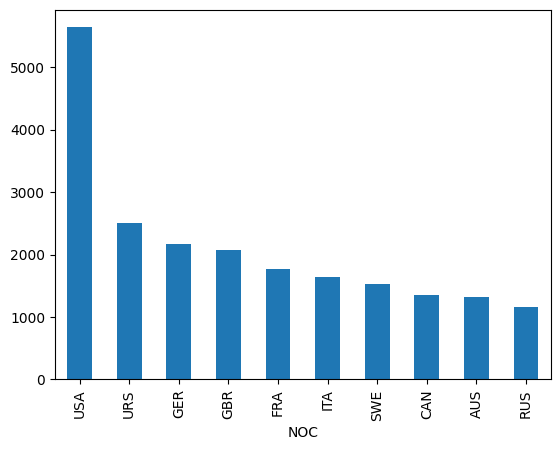

In [10]:
df.groupby('NOC')['Medal'].count().sort_values(ascending=False).iloc[:10].plot.bar()

# ITALIA

In [11]:
italydf = df[df['NOC'] == 'ITA']
italydf

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
158,62,Giovanni Abagnale,M,21,198,90,Italy,ITA,2016 Summer,2016,Summer,Rio de Janeiro,Rowing,Rowing Men's Coxless Pairs,Bronze
197,91,Emanuele Abate,M,27,190,80,Italy,ITA,2012 Summer,2012,Summer,London,Athletics,Athletics Men's 110 metres Hurdles,NaN
198,92,Ignazio Abate,M,21,180,73,Italy,ITA,2008 Summer,2008,Summer,Beijing,Football,Football Men's Football,NaN
214,103,Silvano Abba,M,25,0,0,Italy,ITA,1936 Summer,1936,Summer,Berlin,Modern Pentathlon,Modern Pentathlon Men's Individual,Bronze
218,106,Agostino Abbagnale,M,22,188,96,Italy,ITA,1988 Summer,1988,Summer,Seoul,Rowing,Rowing Men's Quadruple Sculls,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270724,135391,Loredana Zugna,F,32,170,55,Italy,ITA,1984 Summer,1984,Summer,Los Angeles,Shooting,"Shooting Women's Sporting Pistol, 25 metres",NaN
270760,135409,Mauro Carlo Zuliani,M,20,175,62,Italy,ITA,1980 Summer,1980,Summer,Moskva,Athletics,Athletics Men's 400 metres,NaN
270761,135409,Mauro Carlo Zuliani,M,20,175,62,Italy,ITA,1980 Summer,1980,Summer,Moskva,Athletics,Athletics Men's 4 x 400 metres Relay,Bronze
270762,135409,Mauro Carlo Zuliani,M,25,175,62,Italy,ITA,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Men's 4 x 400 metres Relay,NaN


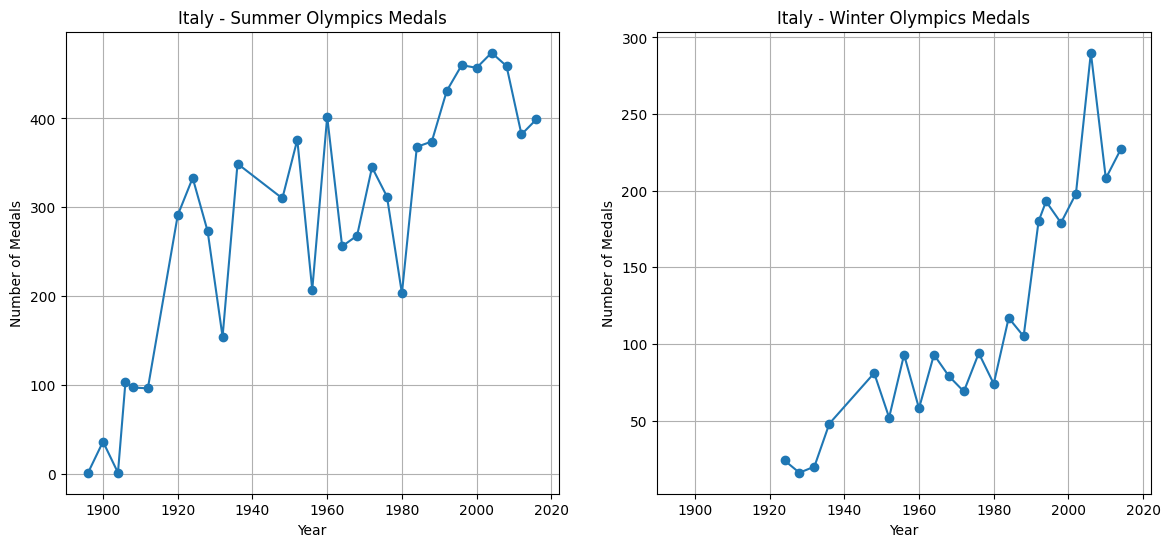

In [28]:
italy_medal = italydf.groupby(['Season', 'Year'])['Medal'].size()

summer = italy_medal.xs('Summer').sort_index()
winter = italy_medal.xs('Winter').sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

summer.plot(ax=axes[0], marker='o')
winter.plot(ax=axes[1], marker='o')

axes[0].set_title('Italy - Summer Olympics Medals')
axes[1].set_title('Italy - Winter Olympics Medals')
for ax in axes:
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Medals')
    ax.grid(True)
